In [1]:
!pip install torch torchvision matplotlib tqdm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
content_path = "/kaggle/input/image-transformation/data/content"
style_path = "/kaggle/input/image-transformation/data/styles"

In [5]:
image_size = 256  # Ensure all images are resized to the same dimensions
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])


In [7]:
class ImageDataset(Dataset):
    def __init__(self, content_dir, style_dir, transform):
        self.content_images = [os.path.join(content_dir, img) for img in os.listdir(content_dir)]
        self.style_images = [os.path.join(style_dir, img) for img in os.listdir(style_dir)]
        self.transform = transform
    
    def __len__(self):
        return len(self.content_images)

    def __getitem__(self, idx):
        content_img = Image.open(self.content_images[idx]).convert("RGB")
        style_img = Image.open(np.random.choice(self.style_images)).convert("RGB")  # Randomly select a style
        
        content_img = self.transform(content_img)
        style_img = self.transform(style_img)

        return content_img, style_img

In [12]:
dataset = ImageDataset(content_path, style_path, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/image-transformation/data/content'

In [8]:
class StyleTransferModel(nn.Module):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.content_layers = ['conv_4']  
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.model = nn.Sequential()
        
        i = 0
        for layer in vgg.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            self.model.add_module(name, layer)
        
        for param in self.model.parameters():
            param.requires_grad = False  # Freeze pre-trained weights

    def forward(self, x):
        outputs = {}
        for name, layer in self.model.named_children():
            x = layer(x)
            if name in self.content_layers or name in self.style_layers:
                outputs[name] = x
        return outputs

In [9]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram / (c * h * w)

class StyleTransferLoss(nn.Module):
    def __init__(self, content_weight=1e5, style_weight=1e10):
        super(StyleTransferLoss, self).__init__()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.mse_loss = nn.MSELoss()

    def forward(self, content_features, style_features, generated_features):
        content_loss = self.mse_loss(generated_features['conv_4'], content_features['conv_4'])

        style_loss = 0
        for layer in style_features:
            gram_generated = gram_matrix(generated_features[layer])
            gram_style = gram_matrix(style_features[layer])
            style_loss += self.mse_loss(gram_generated, gram_style)
        
        total_loss = self.content_weight * content_loss + self.style_weight * style_loss
        return total_loss


In [10]:
def train_model(model, dataloader, optimizer, criterion, epochs=5):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for content_img, style_img in tqdm(dataloader):
            content_img, style_img = content_img.to(device), style_img.to(device)

            optimizer.zero_grad()
            content_features = model(content_img)
            style_features = model(style_img)
            generated_features = model(content_img.clone().requires_grad_(True))

            loss = criterion(content_features, style_features, generated_features)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")


In [11]:
model = StyleTransferModel()
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = StyleTransferLoss()

train_model(model, dataloader, optimizer, criterion, epochs=3)

C:\Users\hpfar\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hpfar\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\hpfar/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:51<00:00, 11.1MB/s] 


NameError: name 'dataloader' is not defined

In [ ]:
torch.save(model.state_dict(), "style_transfer_model.pth")

In [ ]:
def stylize_image(content_image_path, style_image_path, model):
    model.to(device).eval()

    content_image = transform(Image.open(content_image_path).convert("RGB")).unsqueeze(0).to(device)
    style_image = transform(Image.open(style_image_path).convert("RGB")).unsqueeze(0).to(device)

    content_features = model(content_image)
    style_features = model(style_image)
    
    generated_image = content_image.clone().requires_grad_(True)
    optimizer = optim.Adam([generated_image], lr=0.003)

    for i in range(300):
        optimizer.zero_grad()
        generated_features = model(generated_image)
        loss = criterion(content_features, style_features, generated_features)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item():.4f}")

    result = generated_image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
    result = np.clip(result, 0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(result)
    plt.axis("off")
    plt.show()

Iteration 0, Loss: 1662587.0000
Iteration 100, Loss: 141632.8438
Iteration 200, Loss: 124605.0625


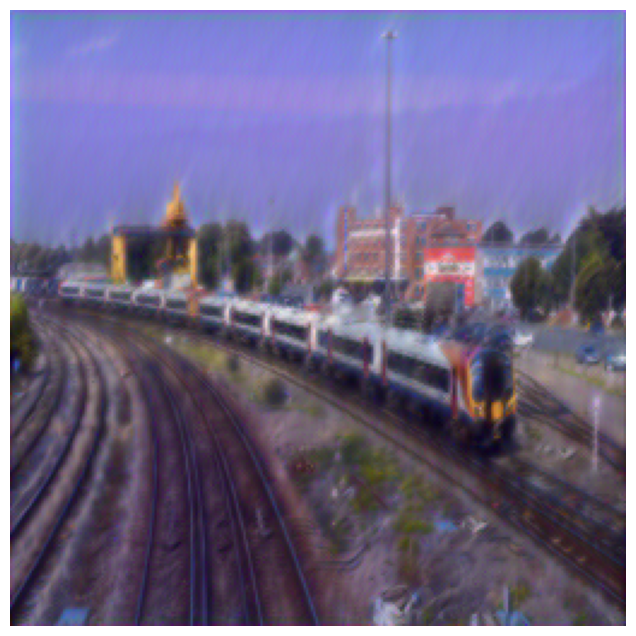

In [ ]:
stylize_image("/kaggle/input/image-transformation/data/content/10.jpg", "/kaggle/input/image-transformation/data/styles/017.jpg", model)

Iteration 0, Loss: 3351107.5000
Iteration 100, Loss: 370468.9375
Iteration 200, Loss: 267765.0625


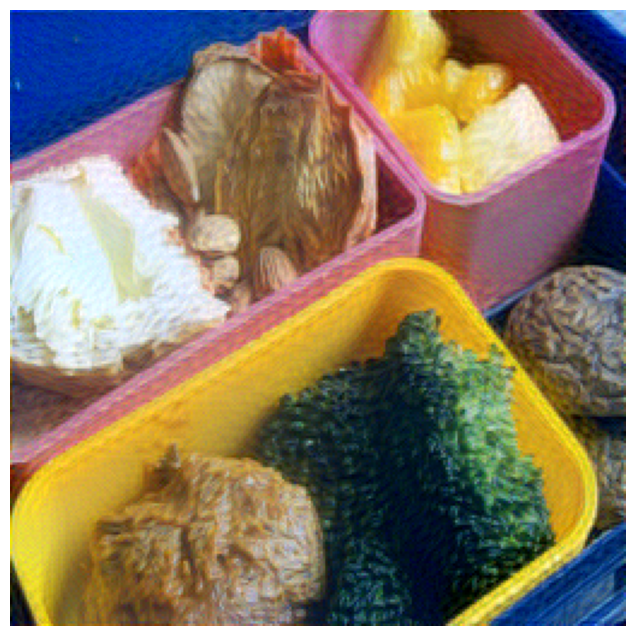

In [ ]:
stylize_image("/kaggle/input/image-transformation/data/content/1.jpg", "/kaggle/input/image-transformation/data/styles/06.jpg", model)

Iteration 0, Loss: 6665734.0000
Iteration 100, Loss: 552874.7500
Iteration 200, Loss: 316573.3125


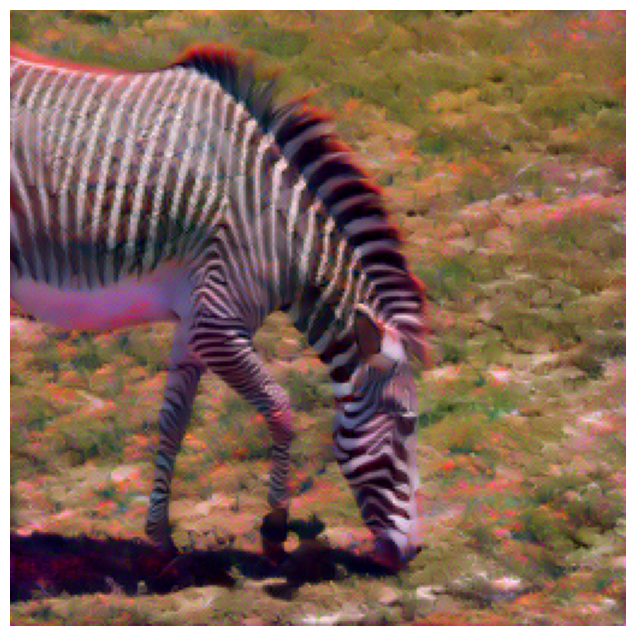

In [ ]:
stylize_image("/kaggle/input/image-transformation/data/content/4.jpg", "/kaggle/input/image-transformation/data/styles/018.jpg", model)

Iteration 0, Loss: 7662306.5000
Iteration 100, Loss: 567958.7500
Iteration 200, Loss: 316557.1562


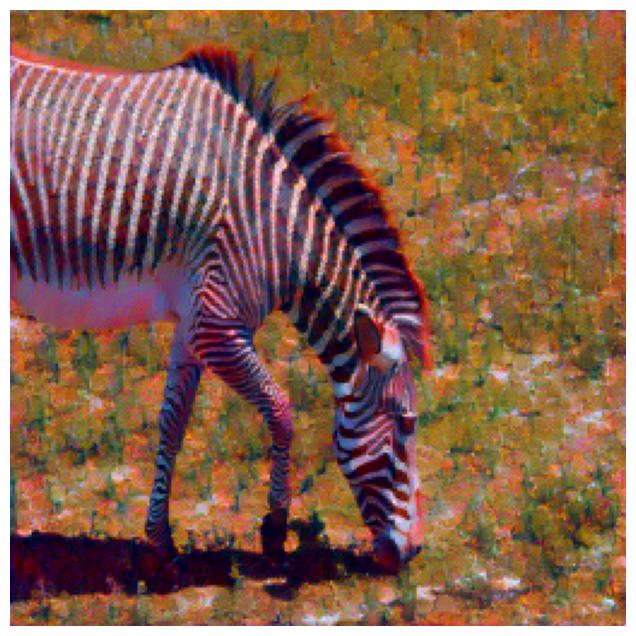

In [ ]:
stylize_image("/kaggle/input/image-transformation/data/content/4.jpg", "/kaggle/input/image-transformation/data/styles/01.jpg", model)